# Exploring COVID-19 Cases in the US
#### Author: Victor Cannestro

## Project Description: 
I think it would be interesting to generate a choropleth map of the number of COVID-19 cases in the US, similar in spirit to the one below from the Wikipedia page titled "2019–20 coronavirus pandemic". However, I'd like to animate the time series data to visualize how the virus spread according to different metrics such as new cases per day and cumulative number of cases. If possible, I’d also be interested in seeing how the number of cases relates to: 
- population density
- proximity to airports 
- economic disparity/spread or income 
- overall political orientation 

etc (at least at a naive level).

[From Wikipedia "2019–20 coronavirus pandemic"](https://upload.wikimedia.org/wikipedia/commons/8/85/COVID-19_outbreak_USA_per_capita_cases_map_counties.svg)


#### Sources of COVID-19 data:
- **[NY Times](https://github.com/nytimes/covid-19-data)**
- [Higher resolution NYC data](https://github.com/nychealth/coronavirus-data)


- Alternatives to possibly consider:

    - [CDC directory of state & territorial health department websites](https://www.cdc.gov/publichealthgateway/healthdirectories/healthdepartments.html)
    - [CDC Cases of Coronavirus Disease (COVID-19) in the U.S.](https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/cases-in-us.html)
    - [Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19)
        - [Cleaned](https://github.com/RamiKrispin/coronavirus)
    
#### Troubleshooting and Additional Resources:
- [The Institute for Health Metrics and Evaluation (IHME)](http://covid19.healthdata.org/united-states-of-america/washington?mkt_tok=eyJpIjoiT0dGbE9UaGhZV0ZsTkRJNSIsInQiOiJpMjBzb2N2WUpYUFM2RWFiQzZ0RGNYNVhMNEQrdytmb2ZVZkNwWSsyUFhiWjR6K1ZCWGtjR3k3c0dBckY0VEJORTVVR3o2cUFGRkJodzdBdW9EOVZZalwvSEhnRGRpTWtGN1hFbUJNSzgzQnVEM01CbEs5SFwvMHZPVjBwUzZuMGZyIn0%3D)
- [The COVID Tracking Project](https://covidtracking.com/)

## Understanding the Methodology Behind and Limitations of the Data


## Python Code

### Imports

In [1]:
import numpy as np
import pandas as pd

import geopandas
from shapely.geometry import Point
import missingno as msn

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5)

from mpl_toolkits.axes_grid1 import make_axes_locatable

from bs4 import BeautifulSoup
import requests

# Test to see if Geopandas is working properly
print(geopandas.__version__)

0.7.0


### Helper Functions for Testing

In [2]:
def returns(return_type):
    '''Checks that the return type of the decorated function is correct,
       and, if not, raises and AssertionError
    
    Args:
        return_type (any return type)
    
    Returns:
        decorator (function):
    
    Notes: 
        `return_type` is made available as a free variable to decorator 
        and wrapper
    '''
    # Complete the returns() decorator
    def decorator(func):
        '''Returns the wrapper function'''
        def wrapper(*args, **kwargs):
            '''Calls function with the given arguments and checks assertion'''
            result = func(*args, **kwargs)
            assert(type(result) == return_type)
            return result
        return wrapper
    return decorator

### Exploring the Time-Series

First, we import the county level time-series data gathered by the **NY Times** on Github (without downloading it) using `pd.read_csv()` and parse the retrieved data into an organized, multi-indexed `DataFrame`. The resulting DataFrame will be indexed by `state`, `county`, and `date` and have three columns: `fips`, `cases`, and `deaths`. Here, `fips` stands for the __F__ederal __I__nformation __P__rocessing __S__eries which are the codes most commonly used by the US Census Bureau. To download the data directly into the current working directory, instead, one could call 

```python
import urllib

url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
filename = 'myfilename.csv'
urllib.request.urlretrieve(url, filename)
```

#### Pandas reminders:
- [pandas.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
- [pandas.DataFrame()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)
- [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)
- [pandas.concat()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html#pandas.concat)

In [3]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the values, set the indices, parse the dates, and alphabetize
df = pd.read_csv(url, 
                 header=0, 
                 index_col=['state','county','date'], 
                 parse_dates=True).sort_index()

In [4]:
df.sample(10)

,,,fips,cases,deaths
state,county,date,,,
Missouri,Howard,2020-04-30,29089.0,2,0
Hawaii,Maui,2020-04-21,15009.0,110,5
Maryland,Carroll,2020-03-26,24013.0,7,0
Georgia,Fayette,2020-06-10,13113.0,254,14
Virginia,Washington,2020-04-26,51191.0,34,3
Florida,Sarasota,2020-06-21,12115.0,962,94
Alabama,DeKalb,2020-05-08,1049.0,136,2
Montana,Fergus,2020-07-18,30027.0,4,0
Virginia,Poquoson city,2020-03-31,51735.0,2,0


Before moving on with further processing let's check to see if there are any missing or suspect values (like negative cases or deaths) in the data and correct them.

In [67]:
neg_cases = df.cases.values[df.cases.values < 0]
assert set(neg_cases) == set(), 'FAILED: there is a negative value' 

In [68]:
assert len(df[df.cases.isna()]) == 0, 'FAILED: there is a nan value' 

In [69]:
neg_deaths = df.deaths.values[df.deaths.values < 0]
assert set(neg_deaths) == set(), 'FAILED: there is a negative value' 

In [70]:
assert len(df[df.deaths.isna()]) == 0, 'FAILED: there is a nan value' 

We can immediately see how easy is is to look up state and county level information using this indexing scheme. Moreover, because the index is sorted by date (which is a collection of `datetime` objects) as well as alphabetically by state and county we can easily isolate the time-series data for each county in preparation for furhter analysis, genreating choropleths, etc. For example, let's peak at the latest King County, WA data:

In [9]:
df.loc[('Washington','King')].tail() # See the latest data for King County

,fips,cases,deaths
date,,,
2020-07-22,53033.0,13661,659
2020-07-23,53033.0,13837,659
2020-07-24,53033.0,14066,662
2020-07-25,53033.0,14274,663
2020-07-26,53033.0,14452,663


Notice how the `cases` and `deaths` columns are expressed as the running aggregate values instead of new reported cases and deaths. Let's write a function that will accept the DataFrame and columns we're interested in and compute the difference between consecutive days.

In [10]:
def dailyChanges(dataframe, cols):
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates
        cols (list): list of column labels
        
    Returns:       
        (pandas DataFrame): quantizing the difference between daily values as
                            the number of new cases per day
    
    Notes:
    '''
    new  = [dataframe[cols].iloc[0]]
    
    # Loop over each date and take the differences
    for i in range(1, len(dataframe)):
        new.append(dataframe[cols].iloc[i] - dataframe[cols].iloc[i-1])
            
    # Convert new into a DataFrame the same indices as dataframe
    new_df = pd.DataFrame(data=new, index=dataframe.index)
    
    # Edit the column names to reflect the daily changes
    new_df.columns = ['new_' + name for name in cols]
    
    return pd.concat((dataframe, new_df), axis=1)

In [11]:
king = dailyChanges(df.loc[('Washington','King')], ['cases','deaths']).apply(abs)
king.tail()

,fips,cases,deaths,new_cases,new_deaths
date,,,,,
2020-07-22,53033.0,13661,659,173,0
2020-07-23,53033.0,13837,659,176,0
2020-07-24,53033.0,14066,662,229,3
2020-07-25,53033.0,14274,663,208,1
2020-07-26,53033.0,14452,663,178,0


The summary statistics of these daily change columns provide us with some broad insights about how King County is being affected:
- `mean` 
   - The average number of reported new cases $\approx 96$
   - The average number of reported new deaths $\approx 5$
   
- `max` 
   - The most reported new cases $\approx 269$
   - The most reported new deaths $\approx 19$
   
- $\dots$

In [12]:
king[['new_cases','new_deaths']].describe()

,new_cases,new_deaths
count,150.000000,150.000000
mean,96.826667,4.513333
std,62.827424,4.029650
min,0.000000,0.000000
25%,48.000000,1.000000
50%,83.500000,3.000000
75%,132.500000,6.750000
max,269.000000,19.000000


Excellent, now we can use the information within `king` to make a variety of graphs to better understand the dynamics of the virus over time and spot any trends that may appear.

In [13]:
def smoother(dataframe, cols, N=7):
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates
        cols (list): column labels
        N (int >= 0): number of days to average
        
    Returns:       
        new (pandas DataFrame): smoothed 7-day rolling average
    
    Notes:
        To calculate the n-day average we make use of a generator 
        expression for readibility and to save memory
        
        https://www.python.org/dev/peps/pep-0289/
    '''
    new  = []
    
    # Loop over each date and take the differences
    for i in range(N, len(dataframe)):       
        # Generator expression to compute the sum
        ave = sum(dataframe[cols].iloc[i-k] for k in [*range(N)]) / N
        new.append(ave)
            
    # Get the indices of the data after the initial N-days and make DataFrame
    idx = dataframe.index[N: len(dataframe)]
    calc = pd.DataFrame(data=new, index=idx)
    
    # Append the averaged data to the initial N-days
    temp = dataframe[cols].iloc[:N].append(calc)
    
    # Edit the column name(s) in temp to include 'average'
    temp.columns = ['average_' + name for name in cols]
    
    # Add the new column(s) to the argument DataFrame
    result = pd.concat((dataframe,temp), axis=1)
    
    return result

In [14]:
smoothed = smoother(king, ['new_cases','new_deaths'], 7)
smoothed.tail(3)

,fips,cases,deaths,new_cases,new_deaths,average_new_cases,average_new_deaths
date,,,,,,,
2020-07-24,53033.0,14066,662,229,3,179.571429,2.000000
2020-07-25,53033.0,14274,663,208,1,183.000000,1.285714
2020-07-26,53033.0,14452,663,178,0,184.428571,1.000000


To make the [dates on the x-axis look more appealing](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/) we will use the `DateFormatter` module from `matplotlib` to customize the display format: `"%X %X"` where each `%X`  represents:

Syntax | Meaning | Example: (July 2020)
---|---|---
`%Y` | 4 digit year | 2020
`%y` | 2 digit year | 20
`%m` | month as a number | 07
`%b` | month as abbreviated name | Jul


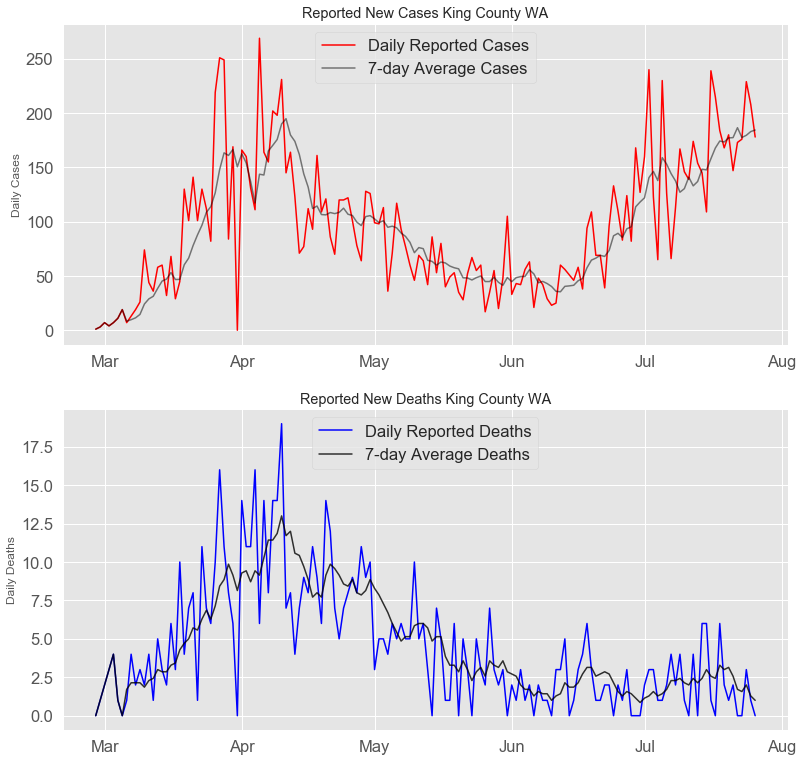

In [31]:
fig, ax = plt.subplots(2, figsize=(13,13))

plt.style.use('ggplot')

# Plot the new reported cases
ax[0].plot(smoothed.index, 
           smoothed.new_cases,  
           color='red',
           label='Daily Reported Cases')

ax[0].plot(smoothed.index, 
           smoothed.average_new_cases, 
           color='black',
           alpha=0.5,
           label='7-day Average Cases')

# Plot the new reported deaths
ax[1].plot(smoothed.index, 
           smoothed.new_deaths, 
           color='blue',
           label='Daily Reported Deaths')

ax[1].plot(smoothed.index, 
           smoothed.average_new_deaths, 
           color='black',
           alpha=0.8,
           label='7-day Average Deaths')

# Set axis labels and titles
ax[0].set(title='Reported New Cases King County WA',
          ylabel='Daily Cases')
ax[1].set(title='Reported New Deaths King County WA',
          ylabel='Daily Deaths')

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")
ax[0].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_formatter(date_form)

# Show the legend and plots
ax[0].legend()
ax[1].legend(loc='upper center')
plt.show()

__Action item:__ Since all the plotting calls look similar so far I should make a function that takes in a dataframe, list of column names (str) to plot (list), a title (str), line labels (str), figsize (tuple), and axis object to determine if a subplot is needed 

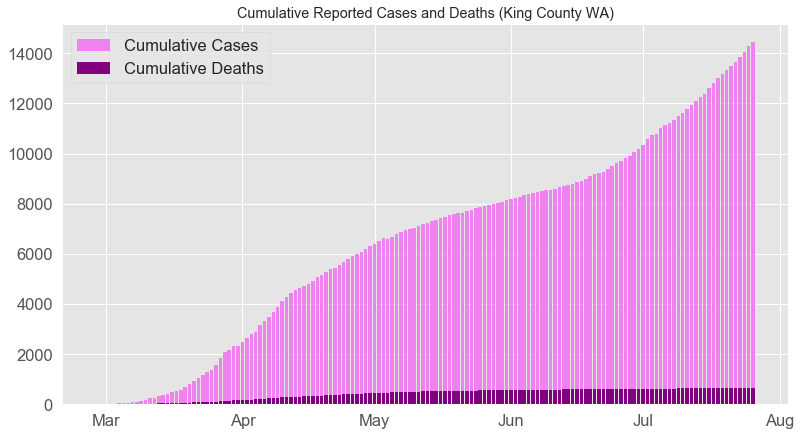

In [43]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

ax.bar(smoothed.index,
       smoothed.cases,
       color='violet',
       label='Cumulative Cases',
       linewidth=0)

ax.bar(smoothed.index,
       smoothed.deaths,
       color='purple',
       label='Cumulative Deaths',
       linewidth=0)

ax.set(title='Cumulative Reported Cases and Deaths (King County WA)')

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.show()

Our next task is to write a function that will automate this process so we can scale the analysis to larger subsets of the US:

- __Washington State__ (for proof of concept)


- __Regions__: 

   - __Northeast__: 
    - `['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']`
   - __Midwest__: 
    - `['IL', 'IN', 'IA', 'KA', 'MI', 'MO', 'MN', 'NE', 'ND', 'OH', 'SD', 'WI']`
   - __South__: 
    - `['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']`
   - __West__: 
    - `['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UR', 'WA', 'WY']`


- __The US as a whole__


Our function should take in a list of 

Rather than aggregating `cases` and `deaths` by `datatime` instance to get the total daily reported cases and deaths in the US, let's import a dataset that already has that information and produce a bar graph.

In [78]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv"

# Read the values, set the indices, parse the dates, and alphabetize
usa = pd.read_csv(url, 
                  header=0, 
                  index_col=['date'], 
                  parse_dates=True).sort_index()
usa.tail()

In [80]:
usa_daily = dailyChanges(usa, ['cases','deaths'])
usa_daily.tail()

,cases,deaths,new_cases,new_deaths
date,,,,
2020-07-22,3980128,143167,69730,1136
2020-07-23,4050126,144283,69998,1116
2020-07-24,4123651,145430,73525,1147
2020-07-25,4190422,146314,66771,884
2020-07-26,4244634,146754,54212,440


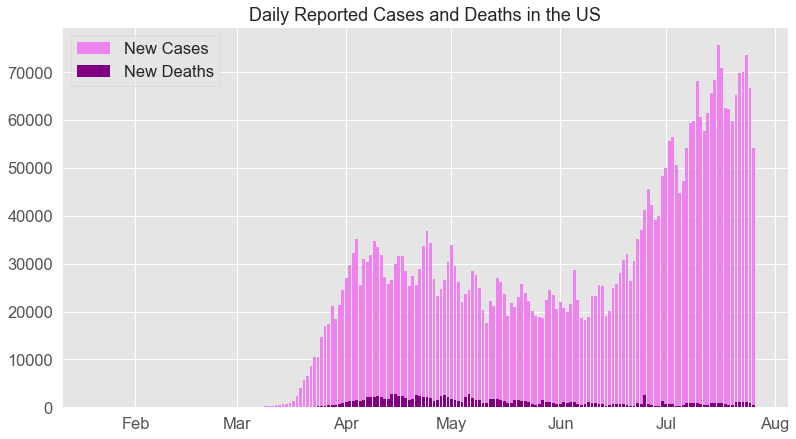

In [104]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

ax.bar(usa_daily.index,
       usa_daily.new_cases,
       color='violet',
       label='New Cases',
       linewidth=0)

ax.bar(usa_daily.index,
       usa_daily.new_deaths,
       color='purple',
       label='New Deaths',
       linewidth=0)

ax.set_title('Daily Reported Cases and Deaths in the US', fontsize=18)

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.show()

In [45]:
# Let's find all the unique dates
dates = king.index.get_level_values(0).unique().sort_values()
dates[:12], dates[:12].month , dates[:12].day

(DatetimeIndex(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
                '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
                '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10'],
               dtype='datetime64[ns]', name='date', freq=None),
 Int64Index([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype='int64', name='date'),
 Int64Index([28, 29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64', name='date'))

__Action item:__ investigate the `'Unknown'` county reported and drop it if necessary

In [46]:
# Now let's see how we can get the county information
df.loc[('Washington')].index.get_level_values(0).unique() 

Index(['Adams', 'Asotin', 'Benton', 'Chelan', 'Clallam', 'Clark', 'Columbia',
       'Cowlitz', 'Douglas', 'Ferry', 'Franklin', 'Garfield', 'Grant',
       'Grays Harbor', 'Island', 'Jefferson', 'King', 'Kitsap', 'Kittitas',
       'Klickitat', 'Lewis', 'Lincoln', 'Mason', 'Okanogan', 'Pacific',
       'Pend Oreille', 'Pierce', 'San Juan', 'Skagit', 'Skamania', 'Snohomish',
       'Spokane', 'Stevens', 'Thurston', 'Unknown', 'Wahkiakum', 'Walla Walla',
       'Whatcom', 'Whitman', 'Yakima'],
      dtype='object', name='county')

In [ ]:
# Find the number of cases accross
new = newcasesWA[newcasesWA.index.get_level_values(1) == dates[10]].swaplevel(0,1).reset_index(1)
new.columns = ['NAME','new cases']
new

In [ ]:
def plotNewCases(dataf, title, fname):
    '''
    
    '''
    fig, ax = plt.subplots(figsize=(14,8))

    _ = ax.bar(dataf.index, dataf['cases'])

    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.title(title, fontsize=25)
    plt.grid(True)
    plt.savefig(fname)

In [ ]:
countiesWA = df.loc[('Washington')].index.get_level_values(0).unique() # get the counties

for i in range(len(countiesWA)):
    newcases = dailynums(df.loc[('Washington',countiesWA[i])], ['cases']).apply(abs)
    titles = ['New COVID-19 Cases '+str(c)+' County WA' for c in countiesWA]
    plotNewCases(newcases, titles[i], fname=titles[i])

In [ ]:
'''
counties = df.loc[('New Jersey')].index.get_level_values(0).unique()

fig, ax = plt.subplots(figsize=(16,12))

for i in counties:
    df.loc[('New Jersey', i)].cases.plot()
    
plt.title("Cumulative COVID-19 Cases")
ax.legend(counties)
plt.ylabel('Cumulative Reported Cases')
plt.grid(True) 
'''

In [ ]:
dates = sorted(df.index.get_level_values(2).unique())
dates

In [ ]:
bydates = df.reset_index().set_index('date').sort_index()
bydates.loc['2020-05-31']

In [ ]:
bydates.index.unique()

In [ ]:
date = bydates.index.unique()[-1]
bydates.loc[date]

In [ ]:
d = df.loc[('Washington','King')].head()
d

In [ ]:
d[['cases','deaths']].iloc[3]

In [ ]:
dailynums(d,['cases','deaths']) # test to see if it's working 

### Underlying US County and State Boundary Maps

The data was obtained through the the US Census Bereau, which provided the `.shp` files of the boudary data. An [online file conversion tool](https://mygeodata.cloud/converter/) was then used to generate `geojson` files from the raw boundary data. 

- https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
- https://eric.clst.org/tech/usgeojson/

- https://github.com/johan/world.geo.json/tree/master/countries/USA


- [State FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696)
- [County FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

In [48]:
# State FIPS Codes
url="https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

In [49]:
 def getStatefips(bsoup):
    '''
    Args:
        bsoup (BeautifulSoup object): takes BeautifulSoup(html_content, "lxml")
        
    Returns:
        statefips (pandas DataFrame): of `name`, `fips`, and `postal code` information
        
    Notes:
        the slicing bounds really should be found in some better way
    '''
    fips = []
    countyName = []
    stateName = []
    for tr in bsoup.find_all('tr')[29:-6]: #Found bounds manually
        tds = tr.find_all('td')
        fips.append(tds[0].text.replace('\r\n\t\t\t\t',''))
        countyName.append(tds[1].text.replace('\r\n\t\t\t\t',''))
        stateName.append(tds[2].text.replace('\r\n\t\t\t\t',''))

    statefips = pd.DataFrame()
    statefips['name'] = fips
    statefips['postal code'] = countyName
    statefips['fips'] = stateName
    
    return statefips

In [71]:
statefips = getStatefips(soup).set_index('postal code')
statefips

,name,fips
postal code,,
AL,Alabama,01
AK,Alaska,02
AZ,Arizona,04
AR,Arkansas,05
CA,California,06
CO,Colorado,08
CT,Connecticut,09
DE,Delaware,10
FL,Florida,12


In [51]:
# Getting to know GEOJSON file:
county = geopandas.read_file("cb_2018_us_county_20m.geojson")
county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49738 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


__Action item:__ merge `STATEFP` and `postal code` to make it easier to read

__Action item:__ filter by postal codes instead of fips for same reason

In [53]:
# Exclude Alaska, Hawaii, American Samoa, Guam, Northern Mariana Islands, Puerto Rico, and the Virgin Islands for now
states = county[county['STATEFP'].isin(['02','15','60','66','69','72','78']) == False]

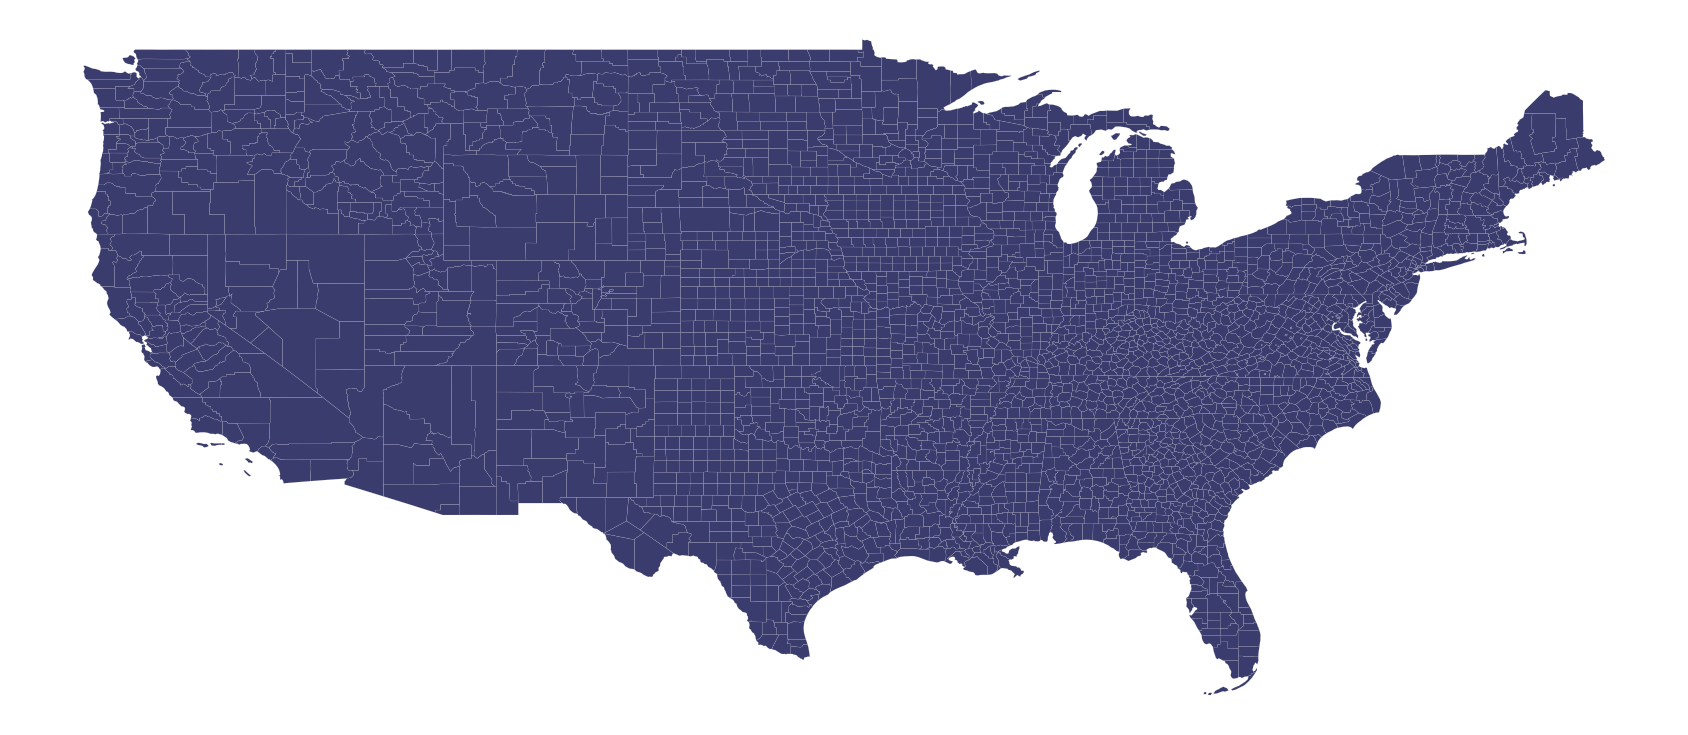

In [62]:
states.plot(figsize=(30,20), 
            color='#3B3C6E',
            linewidth=0.1)

plt.axis('off')
plt.show()

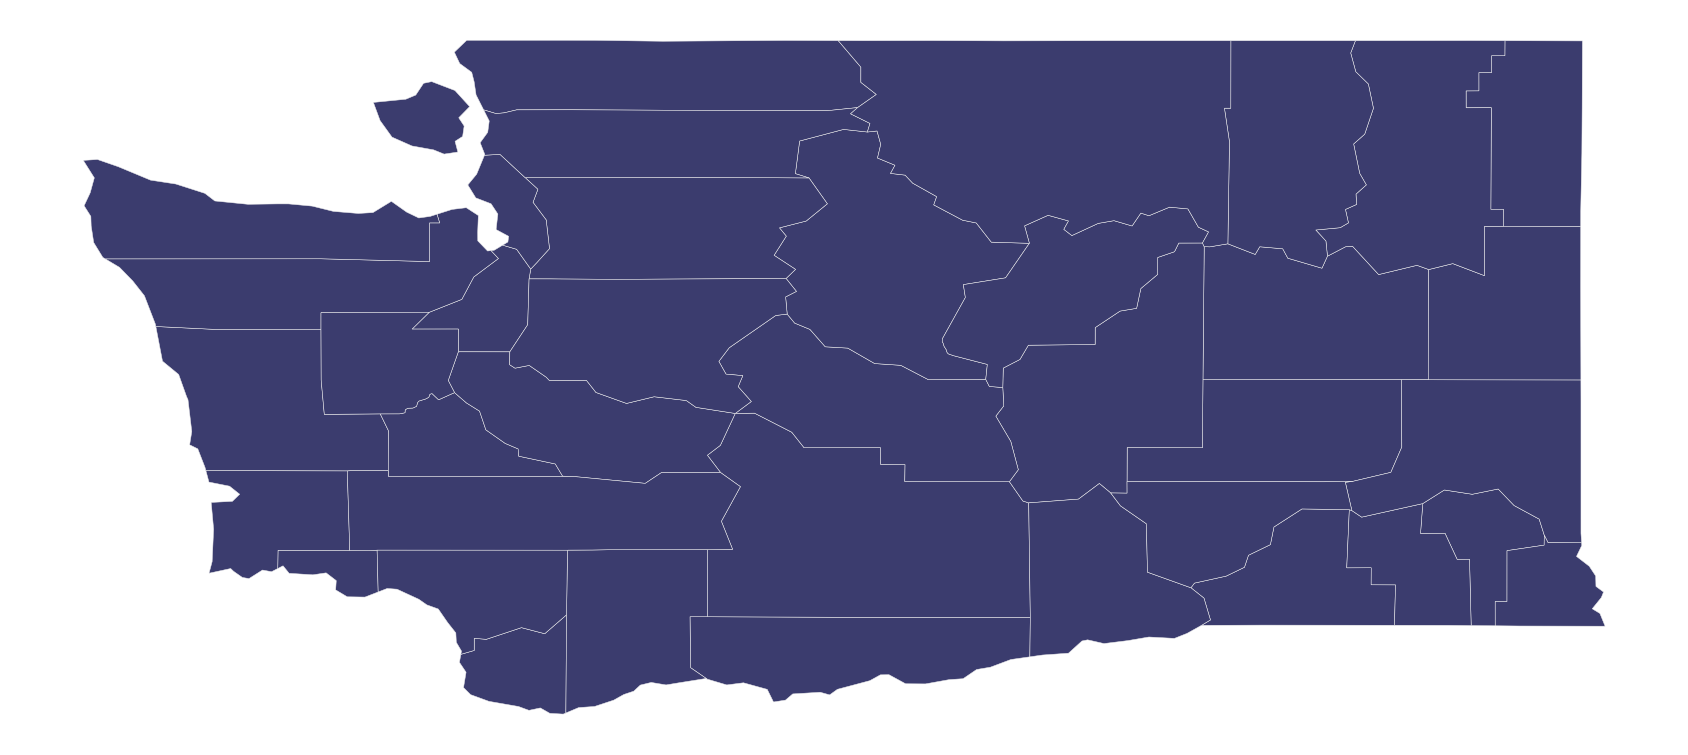

In [55]:
# County map of Washington State
WA = county[county['STATEFP'].isin(['53']) == True]

WA.plot(figsize=(30,20), color='#3B3C6E')
plt.axis('off')
plt.show()

### Making the Choropleths

"When making choropleths, it is important to always use a variable that is normalized for the area being plotted. Further, by using a classification scheme instead of a continuous color scale, we can make the map more easily interpretable."

To make the choropleth map I’ll need to do something like:

`covid19_county_data.plot(column=’cases’, scheme=quantile, k=12, cmap=’Purples’)`

- The color scheme is a graduated sequential scheme
    - I.e. `categorical=False`


__Action item:__ create a function that takes a geopandas DF and loops through each date and creates a choropleth based on the number of cases/100k

In [58]:
newcasesWA = df.loc[('Washington')]

new = newcasesWA[newcasesWA.index.get_level_values(1) == dates[-1]].swaplevel(0,1).reset_index(1)
new.columns = ['NAME','new_cases']
merged = pd.merge_ordered(WA, new, how='left', on='NAME').fillna(0)
    
merged.plot()#column='new cases', cmap='BuGn', edgecolor='black') 
    
plt.title('New COVID-19 cases on '+str(d)[:10],fontsize=25)
plt.axis('off')
#plt.savefig('figs/New COVID-19 cases on '+str(d)[:10]);
plt.show()

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

### Animation

- Make animation of new cases vs time


- Number of total infections vs time